# Homework #5: Generalized Linear Models (GLMs)

## Background

In 2014, the analytics website, FiveThirtyEight, published an analysis of the gender disparity in appearances in comic books at the two large studios, Marvel and DC. You're working for a small upstart comic book company and you want to work to understand what characteristics are associated with a reduction in appearances and thereby learn where gaps in representation can be filled by your firm. Using the data collected by FiveThirtyEight from the Marvel and DC wiki pages, you will fit an appropriate GLM to predict the number of appearances given this data.

### Relevant Datasets
* `marvel-wikia-data.csv`
* `dc-wikia-data.csv`


Article: https://fivethirtyeight.com/features/women-in-comic-books/

Aggregated Data: https://github.com/fivethirtyeight/data/tree/master/comic-characters

Data Sources:
* http://dc.wikia.com/wiki/Main_Page
* http://marvel.wikia.com/Main_Page

## Task 1: Concatenate the Marvel and DC datasets into a single dataset.

The function `pd.concat` will be useful for this. You should also create a new column in each dataset before concatenating that represents the studio for each. This will allow us to distinguish between the impact of one studio vs the other.

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
marvel_df = pd.read_csv('marvel-wikia-data.csv')
dc_df = pd.read_csv('dc-wikia-data.csv')

marvel_df['Studio'] = 'Marvel'
dc_df['Studio'] = 'DC'

combined_df = pd.concat([marvel_df, dc_df], ignore_index=True)

combined_df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year,Studio,YEAR
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0,Marvel,NaN
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0,Marvel,NaN
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0,Marvel,NaN
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0,Marvel,NaN
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0,Marvel,NaN


## Task 2: Subset the data to relevant variables and observations.

If you want to limit the number of levels, a good list of variables would be: `ALIGN`,`SEX`,`ALIVE`,`APPEARANCES`,`ID`,`Studio`. Given that this dataset includes a few `SEX` categories with very few observations, create a new binary variable for a character's `SEX` being Male or not Male. Also, remove any characters that only appear once.

In [3]:
# Columns of relevant variables
relevant_columns = ['ALIGN', 'SEX', 'ALIVE', 'APPEARANCES', 'ID', 'Studio']
subset_df = combined_df[relevant_columns]

# Create a SEX variable
subset_df['Male'] = subset_df['SEX'].apply(lambda x: 1 if x == 'Male' else 0)

# Remove one-time appearances
new_df = subset_df[subset_df['APPEARANCES'] > 1]

new_df.head()

C:\Users\Chanc\AppData\Local\Temp\ipykernel_120304\2047862431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Male'] = subset_df['SEX'].apply(lambda x: 1 if x == 'Male' else 0)


,ALIGN,SEX,ALIVE,APPEARANCES,ID,Studio,Male
0,Good Characters,Male Characters,Living Characters,4043.0,Secret Identity,Marvel,0
1,Good Characters,Male Characters,Living Characters,3360.0,Public Identity,Marvel,0
2,Neutral Characters,Male Characters,Living Characters,3061.0,Public Identity,Marvel,0
3,Good Characters,Male Characters,Living Characters,2961.0,Public Identity,Marvel,0
4,Good Characters,Male Characters,Living Characters,2258.0,No Dual Identity,Marvel,0


## Task 3: Split your data into train/test and fit an appropriate GLM to the training data.

It will be up to you to determine the appropriate choice of distribution or family of the GLM. Look at residual plots and see if there are any red flags with this model.

In [4]:
# Split into train and test sets
train_df, test_df = train_test_split(new_df, test_size=0.3, random_state=42)

# Define the variables
features = ['ALIGN', 'Male', 'ALIVE', 'Studio']
X_train = pd.get_dummies(train_df[features], drop_first=True)
X_test = pd.get_dummies(test_df[features], drop_first=True)
y_train = train_df['APPEARANCES']
y_test = test_df['APPEARANCES']

# Fit a Poisson regression model
X_train = sm.add_constant(X_train)  # add constant term
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Print Poisson model
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            APPEARANCES   No. Observations:                11206
Model:                            GLM   Df Residuals:                    11200
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2808e+05
Date:                Mon, 08 Jul 2024   Deviance:                   8.1200e+05
Time:                        17:35:04   Pearson chi2:                 3.43e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

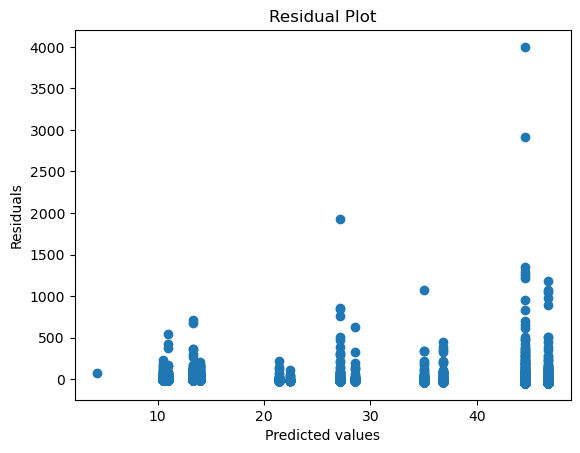

In [5]:
# Predict on the test set
X_test = sm.add_constant(X_test)  # add constant term
y_pred = poisson_model.predict(X_test)

# Residual plots
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [6]:
# Check for overdispersion
mean_residuals = np.mean(residuals)
var_residuals = np.var(residuals)
print(f'Mean of residuals: {mean_residuals}')
print(f'Variance of residuals: {var_residuals}')

Mean of residuals: 0.4449897295188642
Variance of residuals: 12274.171286017963


## Task 4: Interpret coefficients in the context of our original research question of "what characteristics are associated with a reduction in appearances?"

Note: You can ignore any broken assumptions at this point and simply treat it as an effective model.

## Coefficient Interpretations:

1. Const: The intercept (2.3996) is the log of the expected number of appearances for the baseline group. The baseline group here is female characters who are dead, bad characters, and from DC.

2. Male (7.081e-16): The coefficient for being male is close to zero, meaning being male does not significantly affect the number of appearances when other factors are held constant.

3. ALIGN_Good Characters (1.2067): Good characters have a higher log count of appearances compared to bad characters. The expected number of appearances increases by e^1.2067 = 3.34 times for good characters compared to bad characters.

4. ALIGN_Neutral Characters (0.7135): Neutral characters have a higher log count of appearances compared to bad characters. The expected number of appearances increases by e^0.7135 = 2.04 times for neutral characters compared to bad characters.

5. ALIGN_Reformed Criminals (-0.9328): Reformed criminals have a lower log count of appearances compared to bad characters. The expected number of appearances decreases by e^−0.9328 = 0.39 times for reformed criminals compared to bad characters.

6. ALIVE_Living Characters (0.2379): Living characters have a higher log count of appearances compared to dead characters. The expected number of appearances increases by e^0.2379 = 1.27 times for living characters compared to dead characters.

7. Studio_Marvel (-0.0488): Characters from Marvel have a slightly lower log count of appearances compared to characters from DC. The expected number of appearances decreases by e^−0.0488 = 0.95 times for Marvel characters compared to DC characters.


## Summary:
* Good Characters: Characters classified as "good" have significantly more appearances compared to other alignments, suggesting good characters appear more and are safer investments.
* Living Characters: Living characters have more appearances, indicating that characters dying significantly reduces their future appearances.
* Studio: Characters from Marvel have slightly fewer appearances compared to those from DC, which might just show the different choices in character management by the studios.

To avoid a reduction in appearances, the comic company can focus on more diverse alignment categories and having more balanced gender representation, especially since being male did not significantly affect appearances in this dataset. If the company wants to diversify the gender of their characters, they would be most successful with a good character that stays alive for a long time, perhaps modeled after DC characters, though that's not as important. 